# **Importing All Required Libraries**

**TensorFlow is the main library responsible for creating and training the neural network, matplotlib is used for plotting, and VGG19 is a pre-trained neural network used as the base
for the model. Keras API is used for interfacing with the model.**

In [9]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import cv2
import os
import shutil
import numpy as np

from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization, Activation
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import VGG19
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.applications.vgg19 import preprocess_input

# **Image Data Generation**

**Setting up image data generators for training and testing. These augment images on-the-fly
as a form of data preprocessing and augmentation. "train_generator" and "test_generator" used
for feeding the model from their respective directories."**

Images are resized to 331x331 pixels: VGG19 trained on ImageNet is originally sized to 224x224 pxels, but 331x331 is utilized by some networks such as NASNet, and supports more discernible features of images.

Batch size is 64: the datasets are subsetted into sets of 64 due to memory utilization. 64 is a good trade-off between training speed and convergence. Also is a power of 2, which is better for memory alignment.

Training dataset hosts 2500> images belonging to 8 different manufacturers.

Testing dataset hosts 400 images belonging to those same manufacturers. 

In [10]:
IMAGE_SIZE = 331
BATCH_SIZE = 64

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=preprocess_input
)

# Training generator for train folder
train_generator = datagen.flow_from_directory(
    "/Users/connor/Desktop/W24/583 Deep Learning/Course Project MacOS/Car_Brand_Logos/Train",
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    class_mode="categorical",
    color_mode="rgb",
    batch_size=BATCH_SIZE)

# Testing generator for test folder
test_generator = datagen.flow_from_directory(
    "/Users/connor/Desktop/W24/583 Deep Learning/Course Project MacOS/Car_Brand_Logos/Test",
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    class_mode="categorical",
    color_mode="rgb",
    batch_size=BATCH_SIZE)

Found 2513 images belonging to 8 classes.
Found 400 images belonging to 8 classes.


# **Create the  VGG19 Model**
--------------------------------------------------------------------------------------------------------

**Top layers of the VGG19 model (trained on ImageNet) are removed to support classification for automotive logos.**

**Flatten layer** converts the 2D feature maps into a 1D vector.

**Dense layers** learn classification from the features of images.

**Dropout layers** help with overfitting: when a model is too closely aligned to the training data and is not able to generalize— harming its ability to make accurate predictions with validation data.

--------------------------------------------------------------------------------------------------------
"We are creating a CNN model using keras with input shape as (331,331,3) which stands for 331x331 RGB pictures . Refer [link](https://keras.io/api/layers/convolution_layers/convolution2d/)"

"A dropout layer has been added to prevent overfitting [link](https://keras.io/api/layers/regularization_layers/dropout/)"

In [11]:
vgg = VGG19(include_top= False, weights = "imagenet", input_shape=( IMAGE_SIZE,IMAGE_SIZE, 3))
vgg_layer_list = vgg.layers

model = Sequential ()

for layer in vgg_layer_list:
    model.add(layer)
    
for layer in model.layers:
    layer.trainable = False
    
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(8))
model.add(Activation('softmax'))


# Compiling the model: An Adam optimizer with a learning rate @ 0.0001
# Categorical crossentropy as the loss function because of multi-class classification
# (Tracking the accuracy metric)

opt = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999)
model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ block1_conv1 (Conv2D)           │ (None, 331, 331, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 331, 331, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 165, 165, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 165, 165, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 165, 165, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 82, 82, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 82, 82, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 82, 82, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 82, 82, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 82, 82, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 41, 41, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 41, 41, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 41, 41, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 41, 41, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 41, 41, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 20, 20, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 20, 20, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 20, 20, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 20, 20, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 20, 20, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 10, 10, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1024)           │    52,429,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1024)           │             

 Total params: 72,983,112 (278.41 MB)

 Trainable params: 52,958,728 (202.02 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

# **Training the Keras Model**

Iterate over eight training sessions. Callback to save the model as a checkpoint in histories, saves if it has the best performance on the validation data, so far.

In [16]:
# Initial training block
epochs = 10

checkpoint_path = 'model1-{epoch:02d}-{val_loss:.2f}.keras'
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

# Configure the learning rate scheduler
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=0.00001, verbose=1)

for epoch in range(1, 11):  # Assuming 10 epochs
    try:
        history1 = model.fit(
            train_generator,
            steps_per_epoch=len(train_generator),
            epochs=1,  # Run one epoch at a time
            validation_data=test_generator,
            validation_steps=len(test_generator),
            callbacks=[checkpoint, reduce_lr]
        )
    except tf.errors.OutOfRangeError:
        print(f"OutOfRangeError caught during epoch {epoch}, restarting epoch.")
        continue


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7623 - loss: 0.9538
Epoch 1: val_loss improved from inf to 1.40690, saving model to model1-01-1.41.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.7625 - loss: 0.9543 - val_accuracy: 0.7375 - val_loss: 1.4069 - learning_rate: 1.0000e-04
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7775 - loss: 0.9189
Epoch 1: val_loss improved from 1.40690 to 1.38720, saving model to model1-01-1.39.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.7776 - loss: 0.9190 - val_accuracy: 0.7200 - val_loss: 1.3872 - learning_rate: 1.0000e-04
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7777 - loss: 0.9189
Epoch 1: val_loss improved from 1.38720 to 1.27564, saving model to model1-01-1.28.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.7779 - loss: 0.9178 - val_accuracy: 0.7450 - val_loss: 1.2756 - learning_rate: 1.0000e-04
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8073 - loss: 0.7888
Epoch 1: val_loss im

In [17]:
# Load the best model from the previous session
model = load_model('model1-01-1.09.keras')  # Use the actual path of the best model

# Prepare for the next training session
checkpoint_path = 'model2-{epoch:02d}-{val_loss:.2f}.keras'
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

for epoch in range(1, 11):  # Assuming 10 epochs
    try:
        history2 = model.fit(
            train_generator,
            steps_per_epoch=len(train_generator),
            epochs=1,  # Run one epoch at a time
            validation_data=test_generator,
            validation_steps=len(test_generator),
            callbacks=[checkpoint, reduce_lr]
        )
    except tf.errors.OutOfRangeError:
        print(f"OutOfRangeError caught during epoch {epoch}, restarting epoch.")
        continue

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8519 - loss: 0.5721
Epoch 1: val_loss improved from inf to 1.29508, saving model to model2-01-1.30.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.8519 - loss: 0.5722 - val_accuracy: 0.7825 - val_loss: 1.2951 - learning_rate: 1.0000e-04
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8395 - loss: 0.5964
Epoch 1: val_loss did not improve from 1.29508
40/40 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.8395 - loss: 0.5965 - val_accuracy: 0.7600 - val_loss: 1.4177 - learning_rate: 1.0000e-04
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8532 - loss: 0.5322
Epoch 1: val_loss did not improve from 1.29508
40/40 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.8532 - loss: 0.5323 - val_accuracy: 0.7650 - val_loss: 1.3909 - learning_rate: 1.0000e-04
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8598 - loss: 0.5746
Epoch 1: val_loss improved from 1.29508 to 1.18245, saving model to model2-01-1.18.keras
40/40 ━━━━━━━━━

In [18]:
# Load the best model from the previous session
model = load_model('model2-01-1.02.keras')  # Use the actual path of the best model

# Prepare for the next training session
checkpoint_path = 'model3-{epoch:02d}-{val_loss:.2f}.keras'
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

for epoch in range(1, 11):  # Assuming 10 epochs
    try:
        history3 = model.fit(
            train_generator,
            steps_per_epoch=len(train_generator),
            epochs=1,  # Run one epoch at a time
            validation_data=test_generator,
            validation_steps=len(test_generator),
            callbacks=[checkpoint, reduce_lr]
        )
    except tf.errors.OutOfRangeError:
        print(f"OutOfRangeError caught during epoch {epoch}, restarting epoch.")
        continue

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8844 - loss: 0.5132
Epoch 1: val_loss improved from inf to 1.29508, saving model to model3-01-1.30.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.8843 - loss: 0.5126 - val_accuracy: 0.7650 - val_loss: 1.2951 - learning_rate: 1.0000e-04
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8778 - loss: 0.4615
Epoch 1: val_loss improved from 1.29508 to 1.22547, saving model to model3-01-1.23.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.8778 - loss: 0.4620 - val_accuracy: 0.7625 - val_loss: 1.2255 - learning_rate: 1.0000e-04
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8839 - loss: 0.4485
Epoch 1: val_loss improved from 1.22547 to 1.07122, saving model to model3-01-1.07.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.8839 - loss: 0.4476 - val_accuracy: 0.8000 - val_loss: 1.0712 - learning_rate: 1.0000e-04
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8966 - loss: 0.3971
Epoch 1: val_loss di

In [19]:
# Load the best model from the previous session
model = load_model('model3-01-1.07.keras')  # Use the actual path of the best model

# Prepare for the next training session
checkpoint_path = 'model4-{epoch:02d}-{val_loss:.2f}.keras'
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

for epoch in range(1, 11):  # Assuming 10 epochs
    try:
        history4 = model.fit(
            train_generator,
            steps_per_epoch=len(train_generator),
            epochs=1,  # Run one epoch at a time
            validation_data=test_generator,
            validation_steps=len(test_generator),
            callbacks=[checkpoint, reduce_lr]
        )
    except tf.errors.OutOfRangeError:
        print(f"OutOfRangeError caught during epoch {epoch}, restarting epoch.")
        continue

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8930 - loss: 0.4094
Epoch 1: val_loss improved from inf to 1.04254, saving model to model4-01-1.04.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.8932 - loss: 0.4090 - val_accuracy: 0.8050 - val_loss: 1.0425 - learning_rate: 1.0000e-04
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8896 - loss: 0.4374
Epoch 1: val_loss did not improve from 1.04254
40/40 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.8896 - loss: 0.4377 - val_accuracy: 0.7700 - val_loss: 1.3321 - learning_rate: 1.0000e-04
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8877 - loss: 0.4321
Epoch 1: val_loss did not improve from 1.04254
40/40 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.8879 - loss: 0.4319 - val_accuracy: 0.7700 - val_loss: 1.3197 - learning_rate: 1.0000e-04
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8900 - loss: 0.4662
Epoch 1: val_loss did not improve from 1.04254
40/40 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.8903

In [20]:
# Load the best model from the previous session
model = load_model('model4-01-1.04.keras')  # Use the actual path of the best model

# Prepare for the next training session
checkpoint_path = 'model5-{epoch:02d}-{val_loss:.2f}.keras'
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

for epoch in range(1, 11):  # Assuming 10 epochs
    try:
        history5 = model.fit(
            train_generator,
            steps_per_epoch=len(train_generator),
            epochs=1,  # Run one epoch at a time
            validation_data=test_generator,
            validation_steps=len(test_generator),
            callbacks=[checkpoint, reduce_lr]
        )
    except tf.errors.OutOfRangeError:
        print(f"OutOfRangeError caught during epoch {epoch}, restarting epoch.")
        continue

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8972 - loss: 0.3738
Epoch 1: val_loss improved from inf to 1.19038, saving model to model5-01-1.19.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.8971 - loss: 0.3750 - val_accuracy: 0.7775 - val_loss: 1.1904 - learning_rate: 1.0000e-04
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8910 - loss: 0.4427
Epoch 1: val_loss did not improve from 1.19038
40/40 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.8910 - loss: 0.4427 - val_accuracy: 0.7800 - val_loss: 1.2754 - learning_rate: 1.0000e-04
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8881 - loss: 0.4187
Epoch 1: val_loss did not improve from 1.19038
40/40 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.8882 - loss: 0.4191 - val_accuracy: 0.7775 - val_loss: 1.2281 - learning_rate: 1.0000e-04
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8982 - loss: 0.3464
Epoch 1: val_loss did not improve from 1.19038
40/40 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.8982

In [21]:
# Load the best model from the previous session
model = load_model('model5-01-1.06.keras')  # Use the actual path of the best model

# Prepare for the next training session
checkpoint_path = 'model6-{epoch:02d}-{val_loss:.2f}.keras'
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

for epoch in range(1, 11):  # Assuming 10 epochs
    try:
        history6 = model.fit(
            train_generator,
            steps_per_epoch=len(train_generator),
            epochs=1,  # Run one epoch at a time
            validation_data=test_generator,
            validation_steps=len(test_generator),
            callbacks=[checkpoint, reduce_lr]
        )
    except tf.errors.OutOfRangeError:
        print(f"OutOfRangeError caught during epoch {epoch}, restarting epoch.")
        continue

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9192 - loss: 0.2980
Epoch 1: val_loss improved from inf to 1.10875, saving model to model6-01-1.11.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.9191 - loss: 0.2991 - val_accuracy: 0.7900 - val_loss: 1.1088 - learning_rate: 1.0000e-04
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9147 - loss: 0.3059
Epoch 1: val_loss did not improve from 1.10875
40/40 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.9147 - loss: 0.3059 - val_accuracy: 0.7925 - val_loss: 1.1259 - learning_rate: 1.0000e-04
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9132 - loss: 0.3355
Epoch 1: val_loss did not improve from 1.10875
40/40 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.9132 - loss: 0.3355 - val_accuracy: 0.8025 - val_loss: 1.2170 - learning_rate: 1.0000e-04
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9106 - loss: 0.3259
Epoch 1: val_loss improved from 1.10875 to 1.08031, saving model to model6-01-1.08.keras
40/40 ━━━━━━━━━

In [22]:
# Load the best model from the previous session
model = load_model('model6-01-1.08.keras')  # Use the actual path of the best model

# Prepare for the next training session
checkpoint_path = 'model7-{epoch:02d}-{val_loss:.2f}.keras'
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

for epoch in range(1, 11):  # Assuming 10 epochs
    try:
        history7 = model.fit(
            train_generator,
            steps_per_epoch=len(train_generator),
            epochs=1,  # Run one epoch at a time
            validation_data=test_generator,
            validation_steps=len(test_generator),
            callbacks=[checkpoint, reduce_lr]
        )
    except tf.errors.OutOfRangeError:
        print(f"OutOfRangeError caught during epoch {epoch}, restarting epoch.")
        continue

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9211 - loss: 0.3188
Epoch 1: val_loss improved from inf to 1.20135, saving model to model7-01-1.20.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.9211 - loss: 0.3187 - val_accuracy: 0.7925 - val_loss: 1.2014 - learning_rate: 1.0000e-04
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9181 - loss: 0.3055
Epoch 1: val_loss improved from 1.20135 to 1.04089, saving model to model7-01-1.04.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.9182 - loss: 0.3053 - val_accuracy: 0.8200 - val_loss: 1.0409 - learning_rate: 1.0000e-04
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9202 - loss: 0.3358
Epoch 1: val_loss did not improve from 1.04089
40/40 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.9202 - loss: 0.3355 - val_accuracy: 0.7950 - val_loss: 1.3318 - learning_rate: 1.0000e-04
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9260 - loss: 0.3116
Epoch 1: val_loss did not improve from 1.04089
40/40 ━━━━━━━━━

In [23]:
# Load the best model from the previous session
model = load_model('model7-01-1.04.keras')  # Use the actual path of the best model

# Prepare for the next training session
checkpoint_path = 'model8-{epoch:02d}-{val_loss:.2f}.keras'
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

for epoch in range(1, 11):  # Assuming 10 epochs
    try:
        history8 = model.fit(
            train_generator,
            steps_per_epoch=len(train_generator),
            epochs=1,  # Run one epoch at a time
            validation_data=test_generator,
            validation_steps=len(test_generator),
            callbacks=[checkpoint, reduce_lr]
        )
    except tf.errors.OutOfRangeError:
        print(f"OutOfRangeError caught during epoch {epoch}, restarting epoch.")
        continue

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9317 - loss: 0.2847
Epoch 1: val_loss improved from inf to 1.20770, saving model to model8-01-1.21.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.9317 - loss: 0.2848 - val_accuracy: 0.7950 - val_loss: 1.2077 - learning_rate: 1.0000e-04
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9212 - loss: 0.2854
Epoch 1: val_loss did not improve from 1.20770
40/40 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.9214 - loss: 0.2849 - val_accuracy: 0.8150 - val_loss: 1.2137 - learning_rate: 1.0000e-04
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9280 - loss: 0.3046
Epoch 1: val_loss did not improve from 1.20770
40/40 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.9281 - loss: 0.3041 - val_accuracy: 0.7775 - val_loss: 1.3446 - learning_rate: 1.0000e-04
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9340 - loss: 0.2962
Epoch 1: val_loss did not improve from 1.20770
40/40 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.9340

# **Loss and Accuracy Curves**

Plot the training curves for accuracy and loss, called for each training history.

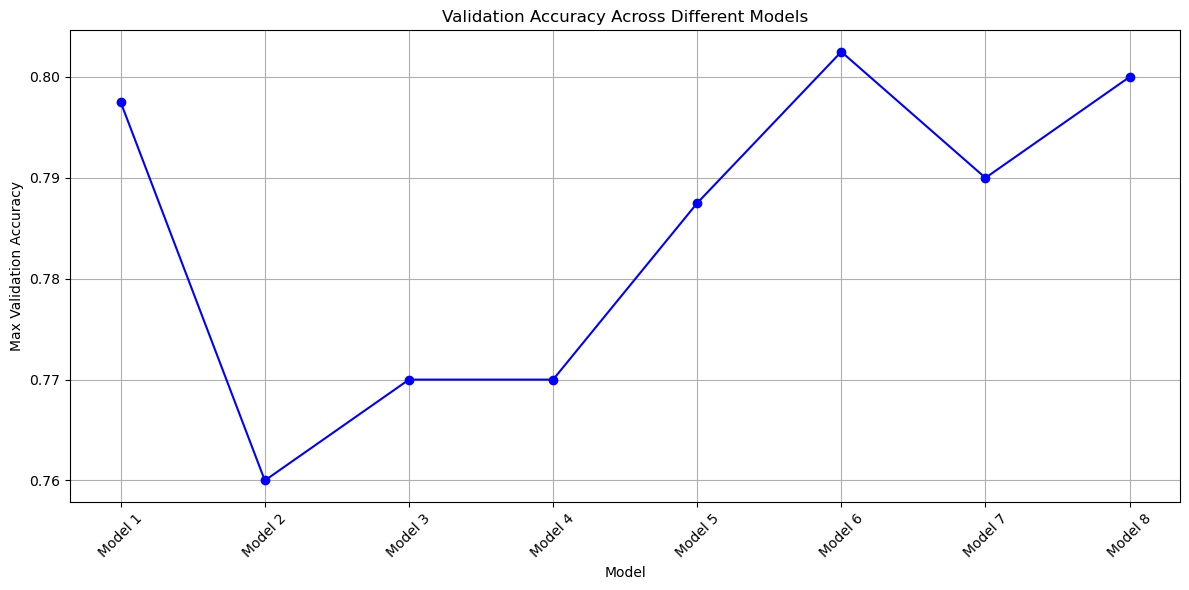

In [29]:
# Assuming history1, history2, etc., contain the training history for each model
accuracies = [
    max(history1.history['val_accuracy']),
    max(history2.history['val_accuracy']),
    max(history3.history['val_accuracy']),
    max(history4.history['val_accuracy']),
    max(history5.history['val_accuracy']),
    max(history6.history['val_accuracy']),
    max(history7.history['val_accuracy']),
    max(history8.history['val_accuracy'])
]

model_labels = ['Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5', 'Model 6', 'Model 7', 'Model 8']

# Create a line plot
plt.figure(figsize=(12, 6))
plt.plot(model_labels, accuracies, marker='o', linestyle='-', color='b')
plt.xlabel('Model')
plt.ylabel('Max Validation Accuracy')
plt.title('Validation Accuracy Across Different Models')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate model labels for better readability
plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels
plt.show()

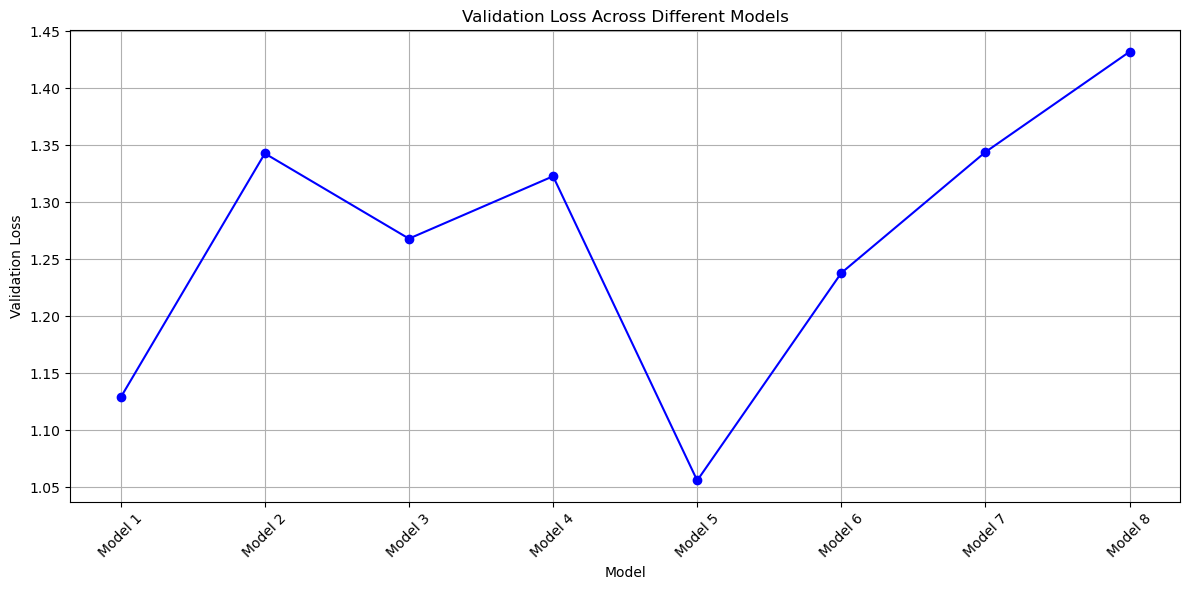

In [30]:
# Assuming history1, history2, etc., contain the training history for each model
loss = [
    max(history1.history['val_loss']),
    max(history2.history['val_loss']),
    max(history3.history['val_loss']),
    max(history4.history['val_loss']),
    max(history5.history['val_loss']),
    max(history6.history['val_loss']),
    max(history7.history['val_loss']),
    max(history8.history['val_loss'])
]

model_labels = ['Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5', 'Model 6', 'Model 7', 'Model 8']

# Create a line plot
plt.figure(figsize=(12, 6))
plt.plot(model_labels, loss, marker='o', linestyle='-', color='b')
plt.xlabel('Model')
plt.ylabel('Validation Loss')
plt.title('Validation Loss Across Different Models')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate model labels for better readability
plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels
plt.show()

# **Accuracy**

Evaluate the trained model's performance on the **test** and **train** datasets and print out the loss and accuracy.

In [47]:
# Evaluate on test data

model = load_model('model5-01-1.06.keras')

test_score = model.evaluate(test_generator, steps=len(test_generator))
print("Test Accuracy: {:.2f}%".format(test_score[1] * 100))
print("Test Loss:", test_score[0])

7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.7831 - loss: 1.2007
Test Accuracy: 80.25%
Test Loss: 1.1777077913284302


In [48]:
# Evaluate on training data

train_score = model.evaluate(train_generator, steps=len(train_generator))
print("Train Accuracy: {:.2f}%".format(train_score[1] * 100))
print("Train Loss:", train_score[0])

40/40 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.9591 - loss: 0.1559
Train Accuracy: 95.70%
Train Loss: 0.15553845465183258


# **Cleaning Up and Saving the Model**

Remove any existing saved models in the directory, create a new directroy, and save the trained model there.

"Refer the [docs](https://www.tensorflow.org/guide/keras/save_and_serialize) from the Tensorflow."

In [ ]:
# Path to the model directory
model_dir = '/Users/connor/Desktop/W24/583 Deep Learning/Course Project MacOS/Car_Brand_Logos/content/model'

# Remove the directory if it exists
if os.path.exists(model_dir):
    shutil.rmtree(model_dir)

# Create the directory
os.makedirs(model_dir, exist_ok=True)

# Save the model
model_path = os.path.join(model_dir, 'saved_model.keras')
model.save(model_path)
print(f"Model saved to {model_path}")

# **Reconstruct the model and check the predicted accuracy**

Load and reconstruct the saved model, make predictions and display Accuracy and Loss for the **test** and **train** datasets. Reduced batch sizing for better runtime.

In [ ]:
# Construct the full path to the model file
model_dir = '/Users/connor/Desktop/W24/583 Deep Learning/Course Project MacOS/Car_Brand_Logos/content/model'
desired_model = "saved_model.keras"
model_path = os.path.join(model_dir, desired_model)

# Load the saved model
reconstructed_model = load_model(model_path)
print(f"Model loaded from {model_path}")

# Evaluate on test data
test_score = reconstructed_model.evaluate(test_generator, steps=len(test_generator))
print("Test Accuracy: {:.2f}%".format(test_score[1] * 100))
print("Test Loss:", test_score[0])

# Evaluate on training data
train_score = reconstructed_model.evaluate(train_generator, steps=len(train_generator))
print("Train Accuracy: {:.2f}%".format(train_score[1] * 100))
print("Train Loss:", train_score[0])

# **Label Identification**

Obeserve the available classifications. Should be 8 different manufacturers.

In [35]:
class_names=train_generator.class_indices

labels={}
for key, value in class_names.items():
    labels[value]=key

labels

{0: 'hyundai',
 1: 'lexus',
 2: 'mazda',
 3: 'mercedes',
 4: 'opel',
 5: 'skoda',
 6: 'toyota',
 7: 'volkswagen'}

# **Prediction for Sample Images— Classification**

Supplement with images that are focused on the logo, if possible. Displays the image (removed due to crashes), and gets result for the supplied image through ".predict". Resizing occurs to provided image. 
- (display_image) was removed due to recurring problems with Python3 becoming unresponsive. Unable to navigate a timely solution, image is available through the explorer. 


In [40]:
import cv2
import numpy as np
import tensorflow as tf

sample_model = load_model('model5-01-1.06.keras')

def display_image(image):
    cv2.imshow('Image', image)
    cv2.waitKey(5000)
    cv2.destroyAllWindows()

def GetResultForImage(image_location):
    img = cv2.imread(image_location, cv2.IMREAD_UNCHANGED)
    
    print('Original Dimensions:', img.shape)
    
    resized = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
    result = np.expand_dims(resized, axis=0)
    result = sample_model.predict(result)
    print(labels[np.argmax(result)])
    
    # Display the resized image using OpenCV
    #display_image(resized)

**Displays results for predictions**— formatting "GetResultForImage("image_name.jpg")"

In [42]:
GetResultForImage("/Users/connor/Desktop/W24/583 Deep Learning/Course Project MacOS/Demonstration Images/skoda.jpg")
GetResultForImage("/Users/connor/Desktop/W24/583 Deep Learning/Course Project MacOS/Demonstration Images/toyota.jpg")
GetResultForImage("/Users/connor/Desktop/W24/583 Deep Learning/Course Project MacOS/Demonstration Images/volkswagen.jpg")
GetResultForImage("/Users/connor/Desktop/W24/583 Deep Learning/Course Project MacOS/Demonstration Images/lexus.jpg")
GetResultForImage("/Users/connor/Desktop/W24/583 Deep Learning/Course Project MacOS/Demonstration Images/mazda.jpg")
GetResultForImage("/Users/connor/Desktop/W24/583 Deep Learning/Course Project MacOS/Demonstration Images/mercedes.jpg")
GetResultForImage("/Users/connor/Desktop/W24/583 Deep Learning/Course Project MacOS/Demonstration Images/opel.jpg")
GetResultForImage("/Users/connor/Desktop/W24/583 Deep Learning/Course Project MacOS/Demonstration Images/hyundai.jpg")

Original Dimensions: (300, 670, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
skoda
Original Dimensions: (1000, 1500, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
toyota
Original Dimensions: (183, 275, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
volkswagen
Original Dimensions: (206, 244, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
lexus
Original Dimensions: (960, 1440, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
mazda
Original Dimensions: (410, 731, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
mercedes
Original Dimensions: (191, 170, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
opel
Original Dimensions: (896, 1600, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
hyundai
